# Regressione Trento

In questo notebook si cerca di analizzare i dati sulla potenza solo della zona urbana di Trento, questo significa che limitiamo i nostri approfondimenti su un numero molto limitato di squareid in cui in generale avremo un maggior consumo medio rispetto a quello del Trentino. I passaggi saranno gli stessi del problema di regressione rispetto ai dati di tutto il Trentino quindi il notebook sarà intervallato meno da spiegazioni dei passaggi mentre ci si concentrerà maggiormente sulla discussione dei risultati

In [263]:
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [264]:
#Giorno
col_stran_nov_df_day = pd.read_csv('../../data/processed/Regressione/Trentino/df_day_trento_nov.csv')
col_stran_dec_df_day = pd.read_csv('../../data/processed/Regressione/Trentino/df_day_trento_dec.csv')
col_stran_dec_df_day['DAY'] = col_stran_dec_df_day['DAY'] + 30 #così dopo concateno con novembre e i giorni vanno da 1 a 61

#Notte
col_stran_nov_df_nig = pd.read_csv('../../data/processed/Regressione/Trentino/df_night_trento_nov.csv')
col_stran_dec_df_nig = pd.read_csv('../../data/processed/Regressione/Trentino/df_night_trento_dec.csv')
col_stran_dec_df_nig['DAY'] = col_stran_dec_df_nig['DAY'] + 30 

In [265]:
col_stran_df_day = pd.concat([col_stran_nov_df_day, col_stran_dec_df_day], axis=0)
col_stran_df_nig = pd.concat([col_stran_nov_df_nig, col_stran_dec_df_nig], axis=0)

Creo la colonna POW_TO_PRED come fatto per la regressione rispetto a tutto il Trentino ponendo come dato nel dataset la potenza del giorno stesso mentre come il target viene assunto questa nuova colonna POW_TO_PRED

In [266]:
dati_day = col_stran_df_day.iloc[:, 1:].drop(['TRENTO', 'HIGH_POW'], axis=1)
dati_nig = col_stran_df_nig.iloc[:, 1:].drop(['TRENTO', 'HIGH_POW'], axis=1)

Ho tolto le colonne TRENTO e HIGH_POW perchè la prima mi serviva solo per discriminare quale squareid fosse veramente e quale no, mentre la seconda è presente solamente perchè il dataset della classificazione e per la regressione sono centrati entrambi su Trento però questa colonna nel caso della regressione perde di significato e sarebbe solo un modo per "barare"

In [267]:
dati_day

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SAB,DOM,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER
0,4850,1,4,0,0,0,0,1,0,0,285,5,457,991,533,11.7,16.0,18.177452
1,4850,2,5,0,0,0,0,0,1,0,285,5,459,990,531,11.7,15.2,19.164852
2,4850,3,6,0,0,0,0,0,0,1,285,5,460,990,530,9.9,18.1,17.756735
3,4850,4,0,1,0,0,0,0,0,0,285,5,461,989,528,7.4,9.8,23.338705
4,4850,5,1,0,1,0,0,0,0,0,285,5,462,989,527,7.5,15.4,21.874364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863,5552,57,4,0,0,0,0,1,0,0,133,1,477,995,517,3.3,8.8,7.810229
864,5552,58,5,0,0,0,0,0,1,0,133,1,477,996,518,1.2,5.4,7.455022
865,5552,59,6,0,0,0,0,0,0,1,133,1,478,997,519,3.2,5.9,7.050005
866,5552,60,0,1,0,0,0,0,0,0,133,1,478,998,519,1.2,7.3,7.645067


In [268]:
dati_day['POWER_TO_PRED'] = dati_day['POWER'].shift(-1)
dati_nig['POWER_TO_PRED'] = dati_nig['POWER'].shift(-1)

In [269]:
#Ho un NaN alla fine perch'è l'ultimo giorno di dicembre era un martedì quindi lo elimino
dati_day = dati_day.drop(dati_day.index[-1])
dati_nig = dati_nig.drop(dati_nig.index[-1])

Usando la potenza del giorno successivo devo togliere l'ultima riga del dataframe perchè conterrà sicuramente un valore NaN non avendo a disposizione la potenza del giorno successivo all'ultimo giorno (perchè in caso contrario non sarebbe l'ultimo giorno).

In [270]:
#Giorno
train_day = dati_day[(dati_day['DAY']%2==0)]
test_day = dati_day[dati_day['DAY']%2==1]

#Notte
train_nig = dati_nig[(dati_nig['DAY']%2==0)]
test_nig = dati_nig[dati_nig['DAY']%2==1]

Si nota che il train e il test non vengono creati come al solito usando la funzione train_test_split perchè voglio essere sicuro che l'algoritmo non riesca a capire che io gli sto fornendo i dati di potenza del giorno stesso per predire quella del giorno successivo. Questa cosa si evita certamente mettendo nel train i giorni pari mentre nel test solo i giorni dispari, o comunque tenendo ben separati due giorni successivi cosicchè nelll'addestramento dell'algoritmo quest'ultimo non si accorga del mio escamotage e quindi non impari lo schema che ho imposto io ma impari realmente a predire la potenza del giorno successivo in maniera oggettiva senza "trucchi".

In [271]:
#Tolgo come sempre il target che questa volta è la colonna 'POWER_TO_PRED'
#Giorno
x_train_square_day = train_day.iloc[:, :18]
y_train_day = train_day.iloc[:, 18:]
x_test_square_day = test_day.iloc[:, :18]
y_test_day = test_day.iloc[:, 18:]

#Notte
x_train_square_nig = train_nig.iloc[:, :18]
y_train_nig = train_nig.iloc[:, 18:]
x_test_square_nig = test_nig.iloc[:, :18]
y_test_nig = test_nig.iloc[:, 18:]
#NOTA: '_square' significa che non ho ancora tolto squareid, day o day_id; mi servirà dopo per fare i grafici

### Random Forest

Uso Random Forest per predire la potenza richiesta il giorno seguente

In [272]:

#Giorno
x_train_day = x_train_square_day.iloc[:, 3:].drop(['SUNSET', 'DAWN'], axis=1) #con iloc tolgo SQUAREID, DAY e DAY_ID
x_test_day = x_test_square_day.iloc[:, 3:].drop(['SUNSET', 'DAWN'], axis=1)
y_train_day = y_train_day.values.ravel()
y_test_day = y_test_day.values.ravel() #come nella classificazione perchè negli algoritmi di apprendimento vuole array e non vettori 
#colonna di dataframe

#Notte
x_train_nig = x_train_square_nig.iloc[:, 3:].drop(['SUNSET', 'DAWN'], axis=1)
x_test_nig = x_test_square_nig.iloc[:, 3:].drop(['SUNSET', 'DAWN'], axis=1)
y_train_nig = y_train_nig.values.ravel()
y_test_nig = y_test_nig.values.ravel()

Tolgo come nell'altro caso di regressione le colonne ripetitive come SUNSET, DAWN  e DAY_ID, e quelle fuorvianti come SQUAREID e DAY

In [273]:
rf_day = RandomForestRegressor()
rf_nig = RandomForestRegressor()

In [274]:
rf_day.fit(x_train_day, y_train_day)
rf_nig.fit(x_train_nig, y_train_nig)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Si calcolano e vengono riportate a schermo tramite un grafico le importanze delle features per capire su cosa si basa maggiormente l'algoritmo per effettuare le sue predizioni

In [275]:
# Mi trovo le importanze delle features di Random Forest
feature_importances_day = rf_day.feature_importances_ 
feature_importances_nig = rf_nig.feature_importances_ 

In [276]:
#Giorno
importance_df_day = pd.DataFrame({'Feature': x_train_day.columns, 'Importance': feature_importances_day}) #creo dataframe delle importanze
importance_df_day = importance_df_day.sort_values(by='Importance', ascending=False) #ordino le features dalla più importante alla meno

#Notte
importance_df_nig = pd.DataFrame({'Feature': x_train_nig.columns, 'Importance': feature_importances_nig}) 
importance_df_nig = importance_df_nig.sort_values(by='Importance', ascending=False)

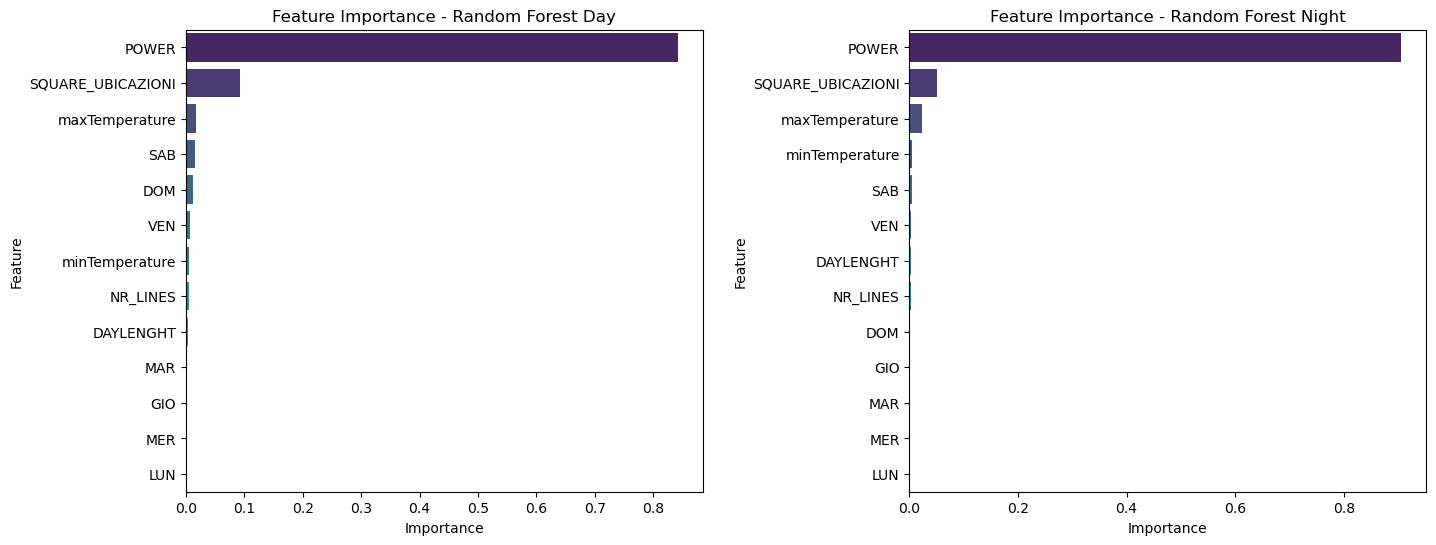

In [277]:
#Plotto i grafici a barre per day e night uno affianco all'altro 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#PLot per Giorno
sns.barplot(x='Importance', y='Feature', data=importance_df_day, order=importance_df_day['Feature'], palette='viridis', ax=ax1)
ax1.set_xlabel('Importance')
ax1.set_ylabel('Feature')
ax1.set_title('Feature Importance - Random Forest Day')

#PLot per Notte
sns.barplot(x='Importance', y='Feature', data=importance_df_nig, order=importance_df_nig['Feature'], palette='viridis', ax=ax2)
ax2.set_xlabel('Importance')
ax2.set_ylabel('Feature')
ax2.set_title('Feature Importance - Random Forest Night')

#Regolo la distanza tra i due grafici
plt.subplots_adjust(wspace=0.4)

plt.show()

Si nota questa volta una grande differenza tra le importanze delle features nelle due fasce orarie. La notte sembra molto simile al caso del Trentino già affrontato infatti nessuna features è realmente predittiva se non POWER. Mentre è significativamente diverso il caso della fascia diurna, infatti in questo caso la colonna SQUARE_UBICAZIONI risente di un peso nettamente maggiore arrivando nell'intorno del 10%. Questa feature esprime quante ubicazioni sono allacciate alla linea elettrica per un singolo squareid (non si può però sapere se è veramente in uso o no la corrente in tutte le ubicazioni, non è fornita questa informazione). Se ci pensiamo però è logico che in un contesto urbano la suddetta colonna trovi grande rilevanza durante il giorno, perchè se durante la notte l'energia elettrica è richiesta solamente dalle strade e dalle fabbriche che non si fermano mai (che abbiamo cercato di manntere fuori dalla nostra trattazione prendendo solo il centro urbano, ma è logico che qualcuna possa essere ancora dentro il dataset) che ci siano tante ubicazioni o poche in un singolo squareid cambia poco, le uniche che usano energia effettivamente sono sempre quelle. Mentre per il giorno tutto cambia perchè la corrente la usano anche gli uffici e le case dove le persone vivono e questo sì che dà rilevanza sul numero di ubicazione per squareid perchè più ubicazioni vorrà dire più energia elettrica consumata. 

Come nel caso precente si fa notare come sia voluto che i giorni settimanali contino senpre molto poco, e sia segno di aver fatto le cose "per bene" però si deve sottolineare che anche in questo caso si è testato l'usare il train_test e non si sono riscontrate differenze imputuabili ad un apprendimento "truccato"

In [278]:
#Calcolo le previsioni del modello

#Giorno
pred_rf_train_day = rf_day.predict(x_train_day)
x_train_square_day.loc[:, 'POW_PRED']= pred_rf_train_day

pred_rf_test_day = rf_day.predict(x_test_day)
x_test_square_day.loc[:, 'POW_PRED'] = pred_rf_test_day

#Notte
pred_rf_train_nig = rf_nig.predict(x_train_nig)
x_train_square_nig.loc[:, 'POW_PRED']= pred_rf_train_nig

pred_rf_test_nig = rf_nig.predict(x_test_nig)
x_test_square_nig.loc[:, 'POW_PRED'] = pred_rf_test_nig

In [279]:
#Faccio una funzione che mi valuti r2 e mse dei regressori che la molto
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print("Mean Squared Error (MSE):", mse)
    print("Coefficient of Determination (R2):", r2)
    
    return mse, r2

Valuto i modelli trovati per le due fasce orarie tramite l'utilizzo dello scarto quadratico medio mse e il coefficiente di determinazione r2

In [280]:
#Giorno
mse_rf_test_day, r2_rf_test_day =evaluate_regression(y_test_day, pred_rf_test_day)
mse_rf_train_day, r2_rf_train_day = evaluate_regression(y_train_day, pred_rf_train_day)

Mean Squared Error (MSE): 87.16524948162713
Coefficient of Determination (R2): 0.9560582241444318
Mean Squared Error (MSE): 16.164647223817198
Coefficient of Determination (R2): 0.9920158265291543


In [281]:
#Notte
mse_rf_test_nig, r2_rf_test_nig =evaluate_regression(y_test_nig, pred_rf_test_nig)
mse_rf_train_nig, r2_rf_train_nig = evaluate_regression(y_train_nig, pred_rf_train_nig)

Mean Squared Error (MSE): 52.18515434715615
Coefficient of Determination (R2): 0.9508683969069459
Mean Squared Error (MSE): 8.637041036322564
Coefficient of Determination (R2): 0.9918436864440572


Si nota in questo caso, rispetto alla regressione sul Trentino totale, che la predizione per i valori diurni e notturni si aggira attorno allo stesso score r2 con differenza all'ordine del millesimo. La differenza più grande con il caso del Trentino risiede nell'errore quadratico medio che è nettamente più elevato sia sul train che sul test, però almeno rimane nell'intorno del rapporto di 4 cioè l'mse sul test è 4 volte più piccolo rispetto all'mse sul test. Questo maggior errore, in termini di valori assoluti, sembra essere in contrasto con il valore così alto del coefficiente di determinazione R^2 che indica una buona correlazione tra il modello e i dati. Però non bisogna farsi trarre in inganno: avendo isolato solamente la zona urbana di Trento è come se nel caso di tutto il Trentino stessimo valutando il mdello solo (o quasi) nel range di consumo medio e alto con varianza che segue pari passo. Questo significa che un valore così alto di MSE è dovuto non alla predizione completamente errata del modello, ma al fatto che stiamo trattando energie molto più elevate in media e che hanno varianza più consistente, il che giustamentre viene rispecchiato dal modello

Cerchiamo comunque di migliorare il modello che potrebbe star facendo overfitting (anche se lieve avendo risultati molto soddisfacenti per il test) quindi usiamo la gridsearch per limitarlo:

In [282]:
def train_regression_model(regressor, param_grid, cv, X, y):
    
    #OUTPUT: regressore ottimizzato con i parametri messi nella griglia di parametri param_grid
    
    #ANNOTAZIONI: X e y sono le X e le y del TRAIN perchè questa funzione mi fitta il regressore che voglio usare con i migliori
    #iperparametri che ho messo nella griglia di parametri param_grid.
    #'param_grid' è la griglia di parametri che deve essere definita come un dizionario quindi:
    #param_grid={
    #            "parametro_1": "[valore1, valore2, ...]",
    #            "parametro_2": "[valore1, valore2]",
    #             ...
    #            }
    #La funzione in outpunt mi restituisce il regressore ottimizzato quindi la devo chiamare così:
    # nome_regressore_ottimizzato = train_regression_model(regressore_da_ottimizzare, param_grid, ...)
    #Nota: il regressore migliore 'best_regressor' NON fitta sui punti, non è stata implementata quella riga di codice perchè
    #se i 'best_params' sono gli stessi tra un tentativo e l'altro quando cambio i parametri di param_grid non ha senso aspettaere
    #che mi faccia il fit, è lo stesso di prima già fatto
    
    
    grid_search = GridSearchCV(regressor, param_grid, cv=cv)
    grid_search.fit(X, y)

    #Printa i migliori parametri trovati
    best_params = grid_search.best_params_
    print("Migliori parametri:", best_params)

    
    best_regressor = regressor.__class__(**best_params) #Crea un nuovo regressore con i migliori parametri
    
    
    return best_regressor, best_params

In [283]:
regressor_day = RandomForestRegressor()
regressor_nig = RandomForestRegressor()
param_grid = {
    "n_estimators": [100, 150, 170],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3],
    "max_depth": [7, 10 ,11], 
    #"min_impurity_decrease": [0.0, 0.01, 0.001], rallenta troppo la ricerca e non sembra dare alcun risultato initeressante
} 
#Utilizzo la stessa griglia di parametri tra day e night perchè non mi aspetto di dover ottimizzare in maniera completamente
#diversa avendo comunque risultati abbastanza simili

A differenza del caso di tutto il Trentino, avendo molti meno dati, riesco ad utilizzare la GridSearchCV senza dover aspettare tempi di calcolo nell'ordine delle ore. Si toglie comunque min_impurity_decrease perchè non  dà segni di volersi schiodare da 0.0 e a questo punto cerco di risparmiare tempo

In [284]:
rf_best_day, best_params_day = train_regression_model(regressor_day, param_grid, 5, x_train_day, y_train_day)

Migliori parametri: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [285]:
rf_best_nig, best_params_nig = train_regression_model(regressor_nig, param_grid, 5, x_train_nig, y_train_day)

Migliori parametri: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}


In [296]:
# Crea un nuovo regressore con i migliori parametri
rf_grid_day = RandomForestRegressor(n_estimators=170, max_depth= 12, min_samples_leaf = 1, min_samples_split = 3,
                                    bootstrap=True, criterion='mse', oob_score=True)
rf_grid_nig = RandomForestRegressor(n_estimators=150, max_depth= 12, min_samples_leaf = 1, min_samples_split = 2,
                                    bootstrap=True, criterion='mse', oob_score=True)

In [297]:
# Addestra il regressore sui dati di addestramento
rf_grid_day.fit(x_train_day, y_train_day)
rf_grid_nig.fit(x_train_nig, y_train_nig)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [298]:
#Predizioni del modello RF ottimizzato 

#Giorno 
pred_rf_grid_train_day = rf_grid_day.predict(x_train_day)
x_train_square_day.loc[:, 'POW_PRED_GRID']= pred_rf_grid_train_day

pred_rf_grid_test_day = rf_grid_day.predict(x_test_day)
x_test_square_day.loc[:, 'POW_PRED_GRID'] = pred_rf_grid_test_day

#Notte
pred_rf_grid_train_nig = rf_grid_nig.predict(x_train_nig)
x_train_square_nig.loc[:, 'POW_PRED_GRID']= pred_rf_grid_train_nig

pred_rf_grid_test_nig = rf_grid_nig.predict(x_test_nig)
x_test_square_nig.loc[:, 'POW_PRED_GRID'] = pred_rf_grid_test_nig


In [299]:
#Valuto i modelli ottimizzati di day e night

#Giorno
mse_rf_grid_test_day, r2_rf_grid_test_day =evaluate_regression(y_test_day, pred_rf_grid_test_day)
mse_rf_grid_train_day, r2_rf_grid_train_day = evaluate_regression(y_train_day, pred_rf_grid_train_day)

Mean Squared Error (MSE): 90.37984353683898
Coefficient of Determination (R2): 0.9544376818723588
Mean Squared Error (MSE): 19.133370877484452
Coefficient of Determination (R2): 0.9905494904990702


In [300]:
#Notte
mse_rf_grid_test_nig, r2_rf_grid_test_nig =evaluate_regression(y_test_nig, pred_rf_grid_test_nig)
mse_rf_grid_train_nig, r2_rf_grid_train_nig = evaluate_regression(y_train_nig, pred_rf_grid_train_nig)

Mean Squared Error (MSE): 49.832448111694326
Coefficient of Determination (R2): 0.9530834373796884
Mean Squared Error (MSE): 8.874109355311525
Coefficient of Determination (R2): 0.9916198130670844


Non si riesce a trovare un modello molto migliore, il modello ottimizzato riscontra gli stessi valori di MSE e R^2 del modello "non ottimizzato". I confronti tramite grafico con la potenza reale rispetto a quella predetta veranno comunque svolti su tutti e due i modelli per avere un effettivo riscontro visivo della somiglianza e per vedere se, anche se commettono in media lo stesso errore, uno dei due si comporta meglio in un caso o in un altro

Si nota però un miglioramento netto rispetto di R^2 al caso del Trentino dove nel train ho un valore circa di 0.01 e nel test di 0.03 nella fascia oraria diurna mentre quella notturna ottiene un miglioramento ancora maggiore: nel train sempre 0.01 mentre nel test di 0.04. Questo mi fa pensare che restringendo il campo ad una ben determinata fascia di energia il modello lavori meglio rispetto ad avere tanti squareid che hanno potenze in media molto diverse tra loro e anche variazioni di potenza tra i giorni molto diversi 

Si nota che si è appianata la differenza tra la previsione notturna rispetto a quella diurna che si era riscontrata nel caso del Trentino

Provo a plottare un grafico sui giorni per i singoli squareid 

In [301]:
#Riordino gli indici della prima colonna (quella senza nome messa da Pandas) perchè sennò con il concat ho errore

#Giorno
x_train_square_day = x_train_square_day.reset_index(drop=True)
x_test_square_day = x_test_square_day.reset_index(drop=True)

#Notte
x_train_square_nig = x_train_square_nig.reset_index(drop=True)
x_test_square_nig = x_test_square_nig.reset_index(drop=True)


In [302]:
#Rimetto insieme il dataset delle x su cui si basa la predizione del target e le y cioè il target, sia nel train che nel test

#Giorno
train_pred_day = pd.concat([x_train_square_day, pd.DataFrame(y_train_day)], axis=1) #axis=1 mi fa unire i dataframe uno affianco
test_pred_day = pd.concat([x_test_square_day, pd.DataFrame(y_test_day)], axis=1) #all'altro e non uso sotto l'altro 

#Notte
train_pred_nig = pd.concat([x_train_square_nig, pd.DataFrame(y_train_nig)], axis=1)
test_pred_nig = pd.concat([x_test_square_nig, pd.DataFrame(y_test_nig)], axis=1)

In [303]:
#Definisco la lista delle colonne dei dataframe appena creati nella cella precedente perchè devo/voglio cambiare il nome della 
#nuova colonna immessa che sennò viene chiamata '0'

#Giorno
columns_tr_day = train_pred_day.columns.to_list()
columns_ts_day =test_pred_day.columns.to_list()

#Notte
columns_tr_nig = train_pred_nig.columns.to_list()
columns_ts_nig =test_pred_nig.columns.to_list()

In [304]:
#Cambio il nome dell'ultima colonna in 'POW_TO_PRED' cioè come l'avevo chiamata inizialmente

#Giorno
columns_tr_day[-1] = 'POW_TO_PRED'
columns_ts_day[-1] = 'POW_TO_PRED'

train_pred_day.columns = columns_tr_day #Aggiorno i nomi delle colonne nel DataFrame
test_pred_day.columns = columns_ts_day

#Notte
columns_tr_nig[-1] = 'POW_TO_PRED'
columns_ts_nig[-1] = 'POW_TO_PRED'

train_pred_nig.columns = columns_tr_nig
test_pred_nig.columns = columns_ts_nig

In [305]:
#Metto insieme test e train 

#Giorno
predictions_day = pd.concat([train_pred_day, test_pred_day], axis=0)

#Notte
predictions_nig = pd.concat([train_pred_nig, test_pred_nig], axis=0)

In [306]:
#Riordino il dataframe delle predizioni in base a squareid e day per avere riscontro sul dataframe iniziale, per avere conferma
#di non aver commesso qualche errore con i concat

#Giorno
predictions_day = predictions_day.sort_values(['SQUAREID', 'DAY'])

#Notte
predictions_nig = predictions_nig.sort_values(['SQUAREID', 'DAY'])

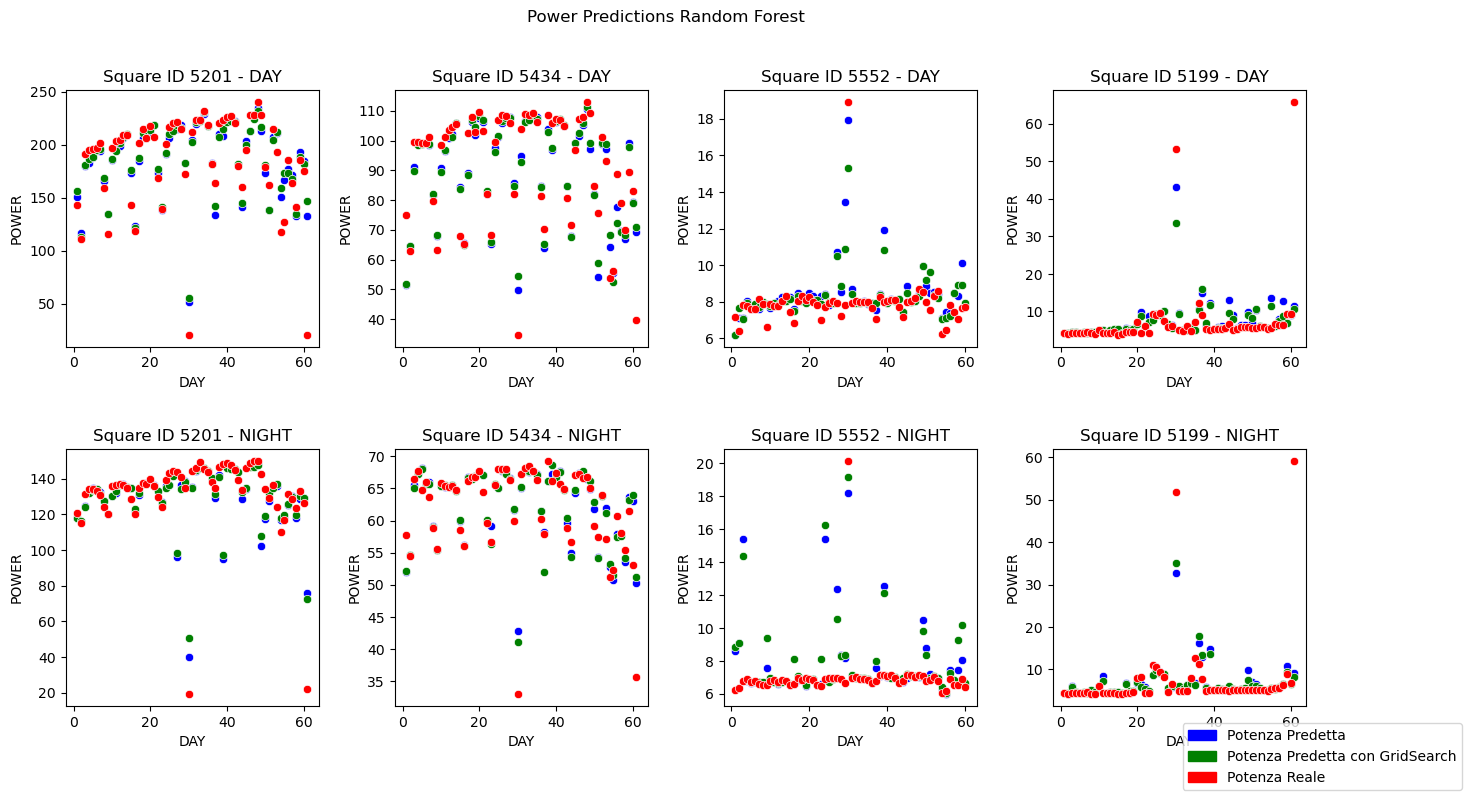

In [307]:
import matplotlib.patches as mpatches

#Fisso gli squareid che voglio vedere perchè rappresentativi di tutti i possibili range di potenza
square_ids = [5201, 5434, 5552, 5199] #Alto, medio, basso e basso cosumo

# Creazione dei subplots per i grafici
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Power Predictions Random Forest')

#Itero sugli square_ids e sulle fasce orarie
for i, square_id in enumerate(square_ids):
    #Filtro i dataframe per Giorno
    filtered_df_day = predictions_day[predictions_day['SQUAREID'] == square_id]
    
    #Filtro i dtaaframe per Notte
    filtered_df_nig = predictions_nig[predictions_nig['SQUAREID'] == square_id]

    #Potto per Giorno
    ax = axs[0, i]
    scatter_day = sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_PRED', color='blue', ax=ax)
    sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_PRED_GRID', color='green', ax=ax)
    sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_TO_PRED', color='red', ax=ax)
    ax.set_xlabel('DAY')
    ax.set_ylabel('POWER')
    ax.set_title('Square ID {} - DAY'.format(square_id))
    
    #PLotto per Notte
    ax = axs[1, i]
    scatter_nig = sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_PRED', color='blue', ax=ax)
    sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_PRED_GRID', color='green', ax=ax)
    sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_TO_PRED', color='red', ax=ax)
    ax.set_xlabel('DAY')
    ax.set_ylabel('POWER')
    ax.set_title('Square ID {} - NIGHT'.format(square_id))

#Creo la legenda in questo modo sennò mi dà warning e non mi mette 1 unica legenda
pred_patch = mpatches.Patch(color='blue', label='Potenza Predetta')
grid_patch = mpatches.Patch(color='green', label='Potenza Predetta con GridSearch')
real_patch = mpatches.Patch(color='red', label='Potenza Reale')

# Aggiunta della legenda unica
fig.legend(handles=[pred_patch, grid_patch, real_patch], loc='lower right')

# Regola lo spazio tra i plot
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Mostra i plot
plt.show()




Vengono riportati i grafici di 4 squareid differenti rispetto a quelli utilizzati per la regressione in tutto il Trentino perchè quelli non sono presenti nel dataset che sto usando ora. Non essendoci centrali che producono elettricità dentro Trento (per fortuna) si è deciso di utilizzare un altro squareid per la potenza mediamente bassa. Quindi da sinistra a destra ho: consumo elevato, consumo medio, consumo basso e consumo basso con "picchi medi". Anche in questo caso i regressori, come con i dati su tutto il Trentino, riesconoo a prevedere meglio quando non ci sono bruschi cambiamenti nell'energia richiesta, casi in cui invee tendono ad "inseguire" l'andamento. Particolare il fatto che in questo caso, diversamente da quanto visto in genere nel caso di tutto il Trentino, si noti una maggior tendenza a "cercare di indovinare" il picco "casuale" negli squareid con potenza generalmente costante nei giorni (con media di potenza richiesta esigua). Si dimostra corretta l'intuizione sull'elevato valore dello score MSE che non stava a significare un enorme divario tra la predizione e i dati reali ma era dato solamente dal fatto che stessimo utilizzando in questo caso potenze generalmente più elevate.

Detto questo non si può effettivamente stabilire un modello migliore e uno peggiore come ci si poteva aspettare guardando i valori di MSE e R^2, inoltre non "agiscono in maniera differente" cioè che ovviamente essendo lo stesso modello di base solo che ottimizzato non penserà in modo differente se per un caso ha un MSE di 85 e per l'altro di 88 con R^2 che variano per quantità sul decimo di punto percentuale. Quindi si conferma l'*andamento* praticamente identico però si notano maggiori differenze negli squareid a bassa potenza perchè lì 2kW di differenza sono veramente percettibili mentre se guardo il primo o il secondo riquadro stiamo parlando di potenze tra i 100 e i 200 kW, impossibile distinguere la differenza in predizione.

Particolare è il fatto che, al contrario del regressore RF per i dati su tutto il Trentino, in questo caso ci sia un maggior errore nel prevedere le fasce notturne piuttosto che quelle diurne, differenza resa palese dagli ultimi due squareid dove ho potenza bassa e mio-bassa. 

## XGBoost

Provo ad utilizzare XGBoost essendo un algoritmo più potente il quale potrebbe darmi risultati migliori, anche se comunque i risultati appena riscontrati e discussi sono già ad un livello più che accettabile avendo uno scarto quadratico medio (mse) minore delle decine, intorno a 9-10 per la predizione sul test in entrambe le fasce orarie

In [308]:
xgb_regressor_day = XGBRegressor()
xgb_regressor_nig = XGBRegressor()

In [316]:
xgb_regressor_day.fit(x_train_day, y_train_day)
xgb_regressor_nig.fit(x_train_nig, y_train_nig)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', predictor=None, ...)

In [317]:
#Mi trovo le importanze delle features di Random Forest

#Giorno
feature_importances_xgb_day = xgb_regressor_day.feature_importances_ 
#Notte
feature_importances_xgb_nig = xgb_regressor_nig.feature_importances_

In [318]:
#Giorno
importance_df_xgb_day = pd.DataFrame({'Feature': x_train_day.columns, 'Importance': feature_importances_xgb_day}) #creo dataframe delle importanze
importance_df_xgb_day = importance_df_xgb_day.sort_values(by='Importance', ascending=False) #ordino le features dalla più importante alla meno

#Notte 
importance_df_xgb_nig = pd.DataFrame({'Feature': x_train_nig.columns, 'Importance': feature_importances_xgb_nig}) 
importance_df_xgb_nig = importance_df_xgb_nig.sort_values(by='Importance', ascending=False)

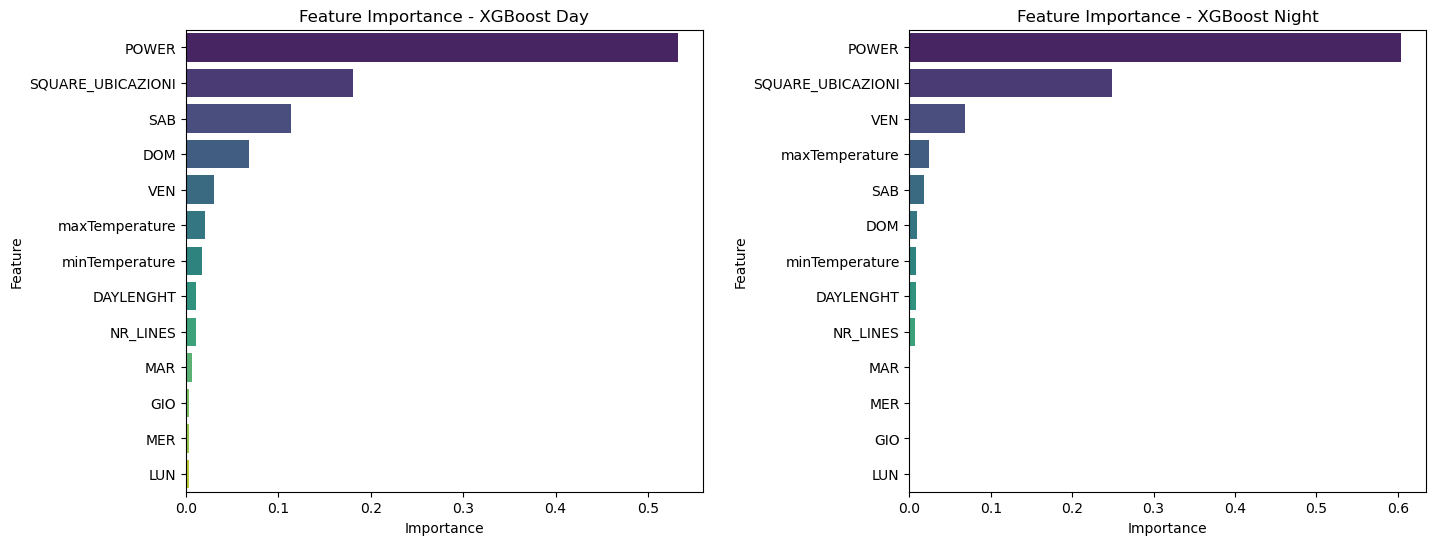

In [319]:
#Plotto i grafici a barre per day e night uno affianco all'altro 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#PLot per Giorno
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb_day, order=importance_df_xgb_day['Feature'], palette='viridis', ax=ax1)
ax1.set_xlabel('Importance')
ax1.set_ylabel('Feature')
ax1.set_title('Feature Importance - XGBoost Day')

#PLot per Notte
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb_nig, order=importance_df_xgb_nig['Feature'], palette='viridis', ax=ax2)
ax2.set_xlabel('Importance')
ax2.set_ylabel('Feature')
ax2.set_title('Feature Importance - XGBoost Night')

#Regolo la distanza tra i due grafici
plt.subplots_adjust(wspace=0.4)

plt.show()

Si nota come le importanze delle features sono molto diverse da quelle del modello di random forest in cui venerdì sabato e domenica sembrano avere un maggiore impatto (come succedeva per il caso del Trentino) insieme a SQUARE_UBICAZIONI in cui in questo caso sia la fascia notturna che diurna prende molta importanza addirittura maggiormente rispetto alla fascia diurna con le Random Forest. Le giornate del weekend che riscuotono importanza più che rilevante probabilemente è lo stesso discorso che abbiamo fatto con la regressione per i dati totali del Trentino infatti probabilmente succede questo perchè durante il weekend il consumo energetico è nettamente minore rispetto ai giorni infrasettimanali e XGBoost è più sensibile a questa informazione. Per questo si era pensato che con XGBoost l'accortezza di come abbiamo diviso train e test fosse necessaria ma si è provato anche con train_test_split e invece il risultato non cambiava come nel caso delle Random Forest

Però le differenze con il caso del Trentino in questo caso sono presenti poichè SQUARE_UBICAZIONI se nel caso del Trentino aveva un peso di circa 0.05 ora è quasi quadruplicato. La predominanza di POWER è comunque incontrastata però da un peso di circa 0.65 siamo passati nell'intorno di 0.55. Questo può voler dire che, come specificato precedentemente, XGBoost cerchi di essere più attento anche a fattori secondari a cui cerca di rilevare una maggior importanza rispetto al modello di Random Forest. Però in questo caso, analizzando solo Trento siamo in un range ristretto di potenze e quindi la maggior parte delle squareid sarà a potenze elevate dove è ovvio che POWER e SQUARE_UBICAZIONI facciano la voce grossa, rispetto ai giorni infrasettimanali o le temperature. In percentuale la popolazione che varia in Trento tra novembre e dicembre è bassa, e sono loro a modificare la potenza richiesta dalle linee elettriche. Mentre posti in montagna hanno una variazione molto elevata di popolazione (rispetto a quella che normalmente resta in quei posti la maggior parte dell'anno) tra giorni feriali e festivi, però in questo caso quei posti non vengono presi in considerazione e quindi si concentra sul predire posti generalmente molto abitati e consumatori elevti di energia elettrica

In [320]:
#Calcolo predizioni di XGBoost su train e test

#Giorno
pred_xgb_train_day = xgb_regressor_day.predict(x_train_day)
x_train_square_day.loc[:, 'POW_PRED_XGB']= pred_xgb_train_day #creo nuova colonna sui dati iniziali che rappresenta la predizione di
#XGBoost per avere un dataframe probabilmente più utile poi per fare qualche grafico

pred_xgb_test_day = xgb_regressor_day.predict(x_test_day)
x_test_square_day.loc[:, 'POW_PRED_XGB'] = pred_xgb_test_day 

#Notte
pred_xgb_train_nig = xgb_regressor_nig.predict(x_train_nig)
x_train_square_nig.loc[:, 'POW_PRED_XGB']= pred_xgb_train_nig

pred_xgb_test_nig = xgb_regressor_nig.predict(x_test_nig)
x_test_square_nig.loc[:, 'POW_PRED_XGB'] = pred_xgb_test_nig

In [321]:
#Valuto r2 e mse per test e train

#Giorno
mse_xgb_test_day, r2_xgb_test_day = evaluate_regression(y_test_day, pred_xgb_test_day)
mse_xgb_train_day, r2_xgb_train_day = evaluate_regression(y_train_day, pred_xgb_train_day)

Mean Squared Error (MSE): 108.61501112265337
Coefficient of Determination (R2): 0.9452449628529119
Mean Squared Error (MSE): 0.14865595896326686
Coefficient of Determination (R2): 0.9999265746448157


In [322]:
#Notte
mse_xgb_test_nig, r2_xgb_test_nig = evaluate_regression(y_test_nig, pred_xgb_test_nig)
mse_xgb_train_nig, r2_xgb_train_nig = evaluate_regression(y_train_nig, pred_xgb_train_nig)

Mean Squared Error (MSE): 56.28638296831724
Coefficient of Determination (R2): 0.9470071467232576
Mean Squared Error (MSE): 0.05019783365532521
Coefficient of Determination (R2): 0.9999525961183465


Un modello con XGBoost senza alcun parametro mi fa ottenere valori minori per R^2 nel test rispetto a quelli di Randomm Forest, provo a migliorare tramite GridSearch notando che sto facendo ENORME OVEERFITTING 

Provo a migliorare l'XGBoost con la GridSearchCV  

In [ ]:
# NON RUNNARE CI METTE TROPPO

regressor_day = XGBRegressor()
regressor_nig = XGBRegressor()

param_grid = {
    "learning_rate": [0.1, 0.11, 0.12], # tasso di apprendimento del modello durante il processo di boosting, basso: lento, aggiustamenti più piccoli ai pesi degli alberi, richiede alto numero di alberi
    "n_estimators": [80, 100, 130], #alto: veloce, cambiamenti significativi ai pesi degli alberi, meno alberi per risultato buono
    "max_depth": [5, 6, 7],
    "min_child_weight": [1, 2, 3], #Peso minimo richiesto per creare un nuovo nodo dell'albero durante la crescita
    "gamma": [0.8, 0.9, 1], #Rappresenta il parametro di riduzione della perdita per la potatura degli alberi
    "subsample": [0.8, 0.9, 1], # Rappresenta la frazione di campioni utilizzati per addestrare ciascun albero
    "reg_lamda": [0.0, 0.1, 0.001] #Pensalità di regolarizzazione L2
    "reg_alpha": [0.0, 0.1, 0.001] #Pensalità di regolarizzazione L1
}

In [ ]:
#NON RUNNARE CI METTE TROPPO

xgb_best_day = train_regression_model(regressor, param_grid, 5, x_train_day, y_train_day)
xgb_best_nig = train_regression_model(regressor, param_grid, 5, x_train_nig, y_train_nig)

In [328]:
#Ci mette troppo quindi uso dei parametri che sono riuscito a trovare qualche giorno fa
xgb_grid_day = XGBRegressor(gamma=0.9, learning_rate=0.13, max_depth=5, min_child_weight=2, n_estimators=130, subsample=0.8,
                            reg_lamda=0.001, reg_alpha=0.001)
xgb_grid_nig = XGBRegressor(gamma=0.9, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.9,
                            reg_lamda=0.001, reg_alpha=0.001)

In [329]:
#Addestro i due XGB
xgb_grid_day.fit(x_train_day, y_train_day)
xgb_grid_nig.fit(x_train_nig, y_train_nig)

[12:52:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "reg_lamda" } are not used.

[12:52:45] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "reg_lamda" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.9, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', predictor=None, ...)

In [330]:
#Predizioni del modello XGB ottimizzato 

#Giorno 
pred_xgb_grid_train_day = xgb_grid_day.predict(x_train_day)
x_train_square_day.loc[:, 'POW_PRED_XGB_GRID']= pred_xgb_grid_train_day

pred_xgb_grid_test_day = xgb_grid_day.predict(x_test_day)
x_test_square_day.loc[:, 'POW_PRED_XGB_GRID'] = pred_xgb_grid_test_day

#Notte
pred_xgb_grid_train_nig = xgb_grid_nig.predict(x_train_nig)
x_train_square_nig.loc[:, 'POW_PRED_XGB_GRID']= pred_xgb_grid_train_nig

pred_xgb_grid_test_nig = xgb_grid_nig.predict(x_test_nig)
x_test_square_nig.loc[:, 'POW_PRED_XGB_GRID'] = pred_xgb_grid_test_nig


In [331]:
#Valuto i modelli ottimizzati di day e night

#Giorno
mse_xgb_grid_test_day, r2_xgb_grid_test_day = evaluate_regression(y_test_day, pred_xgb_grid_test_day)
mse_xgb_grid_train_day, r2_xgb_grid_train_day = evaluate_regression(y_train_day, pred_xgb_grid_train_day)

Mean Squared Error (MSE): 89.08659942607146
Coefficient of Determination (R2): 0.9550896325428362
Mean Squared Error (MSE): 2.7274887638157685
Coefficient of Determination (R2): 0.9986528166604217


In [332]:
#Notte
mse_xgb_grid_test_nig, r2_xgb_grid_test_nig =evaluate_regression(y_test_nig, pred_xgb_grid_test_nig)
mse_xgb_grid_train_nig, r2_xgb_grid_train_nig = evaluate_regression(y_train_nig, pred_xgb_grid_train_nig)

Mean Squared Error (MSE): 34.556082352170215
Coefficient of Determination (R2): 0.967465925054407
Mean Squared Error (MSE): 4.872324196308573
Coefficient of Determination (R2): 0.9953988636010672


Con l'ottimizzazione si è riusciti a far imparare al regressore la fascia oraria notturna. Si nota che entrambe le fasce orarie sembra facciano overfitting ma il più pronunciato rimane quello sulla fascia diurna. Già in questa occasione si può confrontare il modello ottimizzato tramite XGBoost e quello con Random Forest e si vede come non siano così simili i valori di R^2 e MSE, verrà mostrato alla fine un grafico che riporterà proprio un confronto tra i due modelli. Confrontando però R^2 rispetto a quelli trovati nel caso del Trentino ottengo risultati decisamente migliori, sia nel test in cui ho un R^2 migliorato di circa 0.05 e sul train di 0.02 per il caso diurno mentre per quello notturno ho un miglioramento di 0.03 e 0.02 rispettivamente; come nel caso delle Random Forest. Questo riconferma il fatto che la differenza tra gli squareid è molto minore il che consegue che il grado di complessità di predizione sarà minore. L'unico lato negativo è il fatto che avendo un MSE così elevato nelle poche zone a basso consumo troverò un missmatch molto elevato tra predizione e potenza reale.

In questo caso si nota come, a differenza delle Random Forest dove avevo predizioni simili in R^2, con XGBoost ottenga una predizione migliore per la fascia notturna, all'opposto di quanto trovato per XGBoost nel caso del Trentino. 

In [333]:
#Riordino gli indici della prima colonna (quella senza nome messa da Pandas) perchè sennò con il concat ho errore

#Giorno
x_train_square_day = x_train_square_day.reset_index(drop=True)
x_test_square_day = x_test_square_day.reset_index(drop=True)

#Notte
x_train_square_nig = x_train_square_nig.reset_index(drop=True)
x_test_square_nig = x_test_square_nig.reset_index(drop=True)


In [334]:
#Rimetto insieme il dataset delle x su cui si basa la predizione del target e le y cioè il target, sia nel train che nel test

#Giorno
train_pred_day = pd.concat([x_train_square_day, pd.DataFrame(y_train_day)], axis=1) #axis=1 mi fa unire i dataframe uno affianco
test_pred_day = pd.concat([x_test_square_day, pd.DataFrame(y_test_day)], axis=1) #all'altro e non uso sotto l'altro 

#Notte
train_pred_nig = pd.concat([x_train_square_nig, pd.DataFrame(y_train_nig)], axis=1)
test_pred_nig = pd.concat([x_test_square_nig, pd.DataFrame(y_test_nig)], axis=1)

In [335]:
#Definisco la lista delle colonne dei dataframe appena creati nella cella precedente perchè devo/voglio cambiare il nome della 
#nuova colonna immessa che sennò viene chiamata '0'

#Giorno
columns_tr_day = train_pred_day.columns.to_list()
columns_ts_day =test_pred_day.columns.to_list()

#Notte
columns_tr_nig = train_pred_nig.columns.to_list()
columns_ts_nig =test_pred_nig.columns.to_list()

In [336]:
#Cambio il nome dell'ultima colonna in 'POW_TO_PRED' cioè come l'avevo chiamata inizialmente

#Giorno
columns_tr_day[-1] = 'POW_TO_PRED'
columns_ts_day[-1] = 'POW_TO_PRED'

train_pred_day.columns = columns_tr_day #Aggiorno i nomi delle colonne nel DataFrame
test_pred_day.columns = columns_ts_day

#Notte
columns_tr_nig[-1] = 'POW_TO_PRED'
columns_ts_nig[-1] = 'POW_TO_PRED'

train_pred_nig.columns = columns_tr_nig
test_pred_nig.columns = columns_ts_nig

In [337]:
#Metto insieme test e train 

#Giorno
predictions_day = pd.concat([train_pred_day, test_pred_day], axis=0)

#Notte
predictions_nig = pd.concat([train_pred_nig, test_pred_nig], axis=0)

In [338]:
#Riordino il dataframe delle predizioni in base a squareid e day per avere riscontro sul dataframe iniziale, per avere conferma
#di non aver commesso qualche errore con i concat

#Giorno
predictions_day = predictions_day.sort_values(['SQUAREID', 'DAY'])

#Notte
predictions_nig = predictions_nig.sort_values(['SQUAREID', 'DAY'])

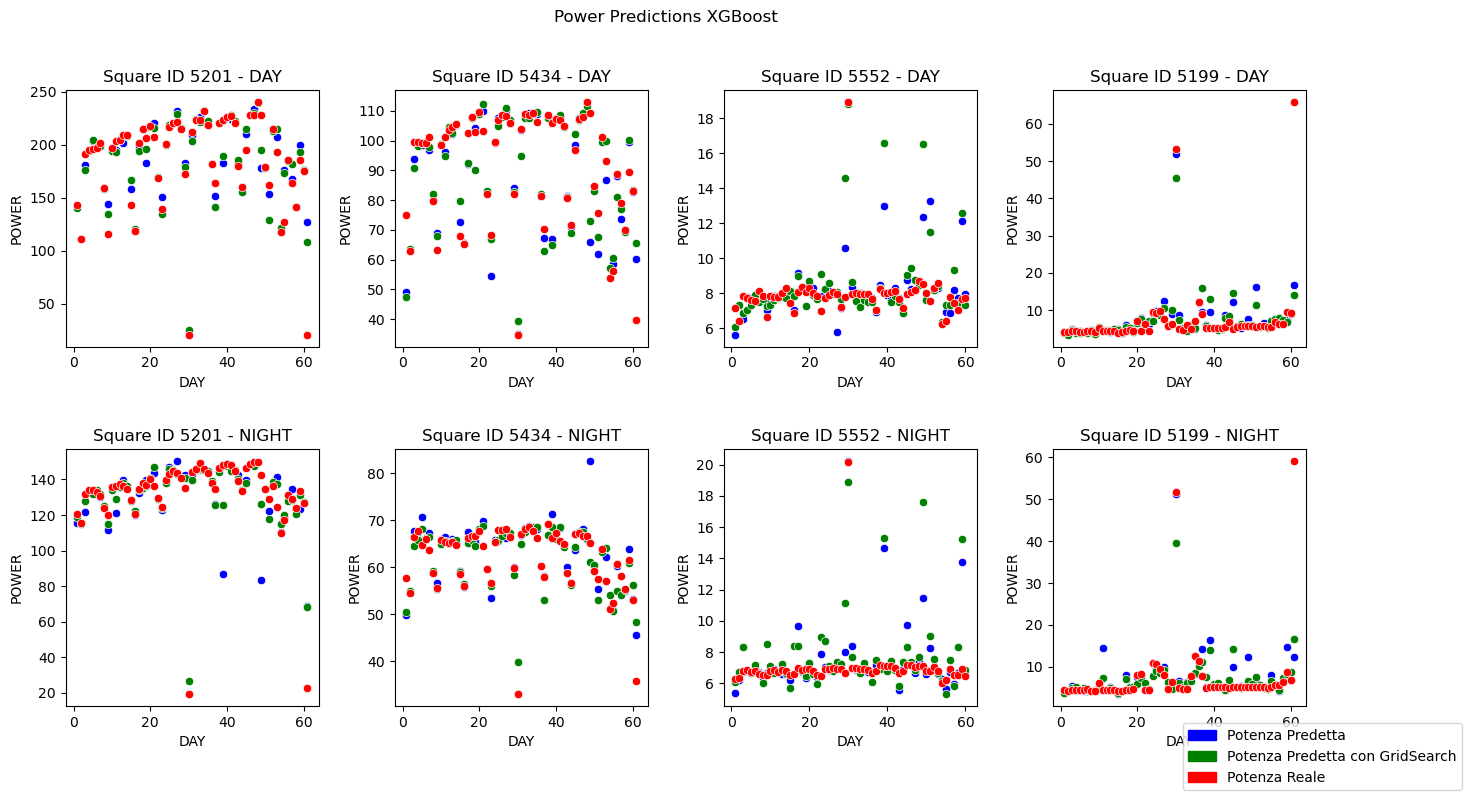

In [339]:
#Fisso gli squareid che voglio vedere perchè rappresentativi di tutti i possibili range di potenza
square_ids = [5201, 5434, 5552, 5199]

#Creo subplot per Giorno e Notte
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Power Predictions XGBoost')

#Itero sugli square_ids e sulle fasce orarie
for i, square_id in enumerate(square_ids):
    #Filtro i dataframe per Giorno
    filtered_df_day = predictions_day[predictions_day['SQUAREID'] == square_id]
    
    #Filtro i dtaaframe per Notte
    filtered_df_nig = predictions_nig[predictions_nig['SQUAREID'] == square_id]

    #Potto per Giorno
    ax = axs[0, i]
    scatter_day = sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_PRED_XGB', color='blue', ax=ax)
    sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_PRED_XGB_GRID', color='green', ax=ax)
    sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_TO_PRED', color='red', ax=ax)
    ax.set_xlabel('DAY')
    ax.set_ylabel('POWER')
    ax.set_title('Square ID {} - DAY'.format(square_id))
    
    #PLotto per Notte
    ax = axs[1, i]
    scatter_nig = sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_PRED_XGB', color='blue', ax=ax)
    sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_PRED_XGB_GRID', color='green', ax=ax)
    sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_TO_PRED', color='red', ax=ax)
    ax.set_xlabel('DAY')
    ax.set_ylabel('POWER')
    ax.set_title('Square ID {} - NIGHT'.format(square_id))

#Creo la legenda in questo modo sennò mi dà warning e non mi mette 1 unica legenda
pred_patch = mpatches.Patch(color='blue', label='Potenza Predetta')
grid_patch = mpatches.Patch(color='green', label='Potenza Predetta con GridSearch')
real_patch = mpatches.Patch(color='red', label='Potenza Reale')

#Aggiungo la legenda unica così da occupare meno spazio
fig.legend(handles=[pred_patch, grid_patch, real_patch], loc='lower right')

#Regolo lo spazio tra i plot
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()


Come previsto il modello ottimizzato è in linea di principio molto simile rispetto al modello non ottimizzato, dove le maggiori differenze risiedono nella ricerca di picchi in cui sembra essere migliore il modello ottimizzato (soprattutto per energie elevate). In questo caso, a differenza di quanto visto con i dati del Trentino, XGBoost sembra performi molto bene nelle zone con elevata potenza e varianza, mentre si nota come commetta molti errori sulle zone a basso consumo. Questo perchè avendo un errore quadratico medio così alto la predizione può avvenire a qualche kW di distanza dal valore reale che però se nei primi squareid dove si parla di centinaia di kW non è un errore tanto percepibile, per le zone in cui i consumi sono molto bassi si nota eccome ed infatti questo difetto si evidenza maggiormente per la squareid 5552 (il terzo riquadro) mentre già in quella seguente sembra trovare un maggiore accordo. Questa considerazione è, come accennato spesso durante tutto il notebook, maggiormente verificata per la fascia diurna dove si riscontrava un MSE nettamente più elevato. Quindi in generale il modello ottimizzato è molto buono, solo che lo è *in generale* e quindi per la maggior parte degli squareid che sono quelli a potenza e varianza elevata; questo sacrifica gli squareid meno numerosi in cui la predizione trasporta la varianza anche in questi casi finendo per ottenere riscontri visibilmente peggiori rispetto al caso del Trentino

## Confronto tra il miglior modello RF e XGB

Per concludere cerchiamo di confrontare i due modelli appena espositi; a differenza dell'analisi di tutto il Trentino qui mi aspetto una leggera miglior performance del modello di Random Forest a causa dei pochi dati che ho per allenare il mio modello

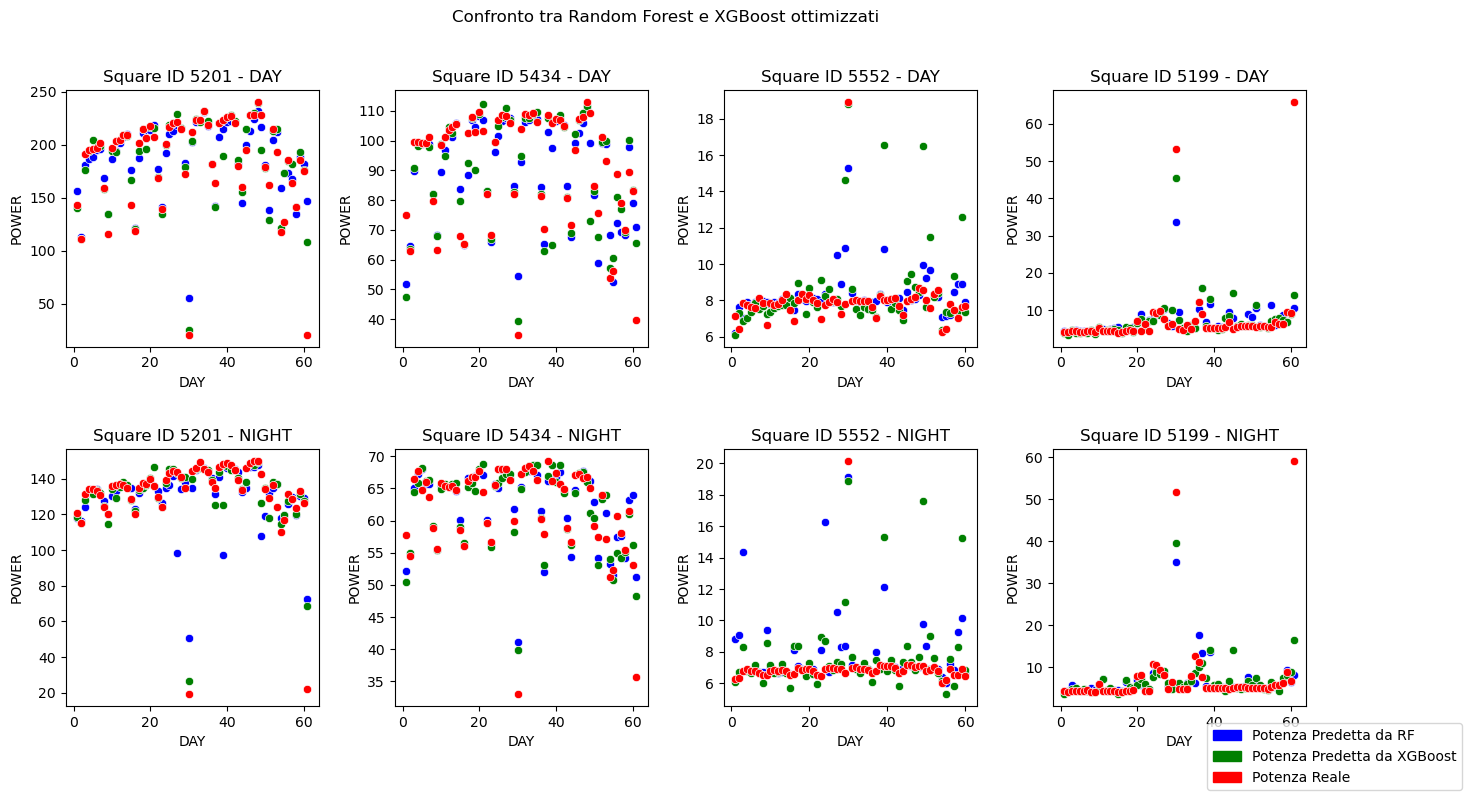

In [340]:
#PLotto il grafico per confrontare modello RF con XGBoost


#Fisso gli squareid che voglio vedere perchè rappresentativi di tutti i possibili range di potenza
square_ids = [5201, 5434, 5552, 5199]

# Creazione dei subplots per i grafici
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Confronto tra Random Forest e XGBoost ottimizzati')

#Itero sugli square_ids e sulle fasce orarie
for i, square_id in enumerate(square_ids):
    #Filtro i dataframe per Giorno
    filtered_df_day = predictions_day[predictions_day['SQUAREID'] == square_id]
    
    #Filtro i dtaaframe per Notte
    filtered_df_nig = predictions_nig[predictions_nig['SQUAREID'] == square_id]

    #Potto per Giorno
    ax = axs[0, i]
    scatter_day = sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_PRED_GRID', color='blue', ax=ax)
    sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_PRED_XGB_GRID', color='green', ax=ax)
    sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_TO_PRED', color='red', ax=ax)
    ax.set_xlabel('DAY')
    ax.set_ylabel('POWER')
    ax.set_title('Square ID {} - DAY'.format(square_id))
    
    #PLotto per Notte
    ax = axs[1, i]
    scatter_nig = sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_PRED_GRID', color='blue', ax=ax)
    sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_PRED_XGB_GRID', color='green', ax=ax)
    sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_TO_PRED', color='red', ax=ax)
    ax.set_xlabel('DAY')
    ax.set_ylabel('POWER')
    ax.set_title('Square ID {} - NIGHT'.format(square_id))

#Creo la legenda in questo modo sennò mi dà warning e non mi mette 1 unica legenda
pred_patch = mpatches.Patch(color='blue', label='Potenza Predetta da RF')
grid_patch = mpatches.Patch(color='green', label='Potenza Predetta da XGBoost')
real_patch = mpatches.Patch(color='red', label='Potenza Reale')

# Aggiunta della legenda unica
fig.legend(handles=[pred_patch, grid_patch, real_patch], loc='lower right')

# Regola lo spazio tra i plot
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Mostra i plot
plt.show()


Il confronto comunque non sembra dare una differenza abissale tra i due modelli però anche qui, come nell'altro caso di regressione, si possono vedere alcuni punti chiave. 
Si nota come XGBoost sembra non riuscire a predire 1 singolo punto che è fuori scala rispetto a tutti gli altri, per questo tenta/spera che anche altri punti siano distaccati dalla massa e questo si nota nell'ultimo e penultimo riquadro dove per il secondo di questi riesce ad azzeccare perfettamente quel singolo punto fuori da tutto in mezzo ai due mesi, ma per farlo deve spendere tanti altri punti che invece si rivelano molto distanti dalla realtà. Questo può farci capire come XGBoost possa essere conveniente da usare se la varianza in media rimane elevata, perche ad esempio con i primi due squareid raffigurati si comporta molto bene, meglio delle Randomm Forest soprattutto nei punti molto isolati perchè ha "bisogno" di imparare a cogliere le varianze e poi riesce ad indovinare molto bene anche quegli outsider rilievo. In quei casi "non paga pegno" nell'indovinare l'outsider perchè effettivamente ci sono altri punti che si discostano dalla maggioranza per un valore significativo, e allora il modello è ottimo. Random Forest invece sembra comportarsi meglio quando si parla di "sbagliare meno in media" cioè riporta un grande accordo con i dati reali ma i veri "outsider" non li trova molto bene, tende a rimanere più vicino alla maggioranza. 

Infine cercando un cofronto con i risultati ottenuti con le regressioni per il Trentino se dobbiamo dire quali siano i migliori modelli sono sicuramente quelli addestrati sul dataset di Trento, perchè devono imparare "meno situazioni/casistiche" a cui, quando le trovano, danno meno rilevanza perchè meno frequenti e quindi riescono a concentrarsi meglio sulla maggioranza dei dati, e quindi performano meglio in generale. I modelli sviluppati su tutto il Trentino invece non lo possono propriamente fare (il concentrarsi sulla maggioranza) perchè non esiste una maggioranza così chiara e netta, anzi: conoscendo il Trentino come regione poco industrializzata e con grande spazio alla natura, e avendo in mente le mappe riportate nella parte di EDA, la maggioranza risiede negli squareid poco energivori e infatti quei modelli performano decisamente meglio su quel tipo di casistica rispetto a quelli ad alta varianza e potenza. 

Da tutte queste considerazioni mi aspetto che se sottoponessi il mio modello a fasce orarie più restrittive in questo caso potrebbe comportarsi meglio rispetto a quanto non sarebbe riuscito a fare il modello su tutto il Trentino, perchè gli squareid analizzati sono più simili tra loro e questo ha portato ad avere una conoscenza migliore delle variazioni tra un giorno e l'altro in una determinata fascia oraria. Questo mi fa pensare che sia più plausibile ottenere buoni risultati per fasce più ristrette in questo caso.

Come fatto in precedenza salvo quindi i modelli ottenuti per entrambe le fasce

In [341]:
from joblib import dump, load

#Definisco i modelli
models = {
    'XGBoost- Day Tn': {'filename': 'XGB_reg_grid_TN_day.pkl', 'value': xgb_grid_day},
    'XGBoost- Night Tn': {'filename': 'XGB_reg_grid_TN_nig.pkl', 'value': xgb_grid_nig},
    'Random Forest- Day Reg Tn': {'filename': 'RF_reg_grid_TN_day.pkl', 'value': rf_grid_day},
    'Random Forest- Night Reg Tn': {'filename': 'RF_reg_grid_TN_nig.pkl', 'value': rf_grid_nig}
}

#Salvo i modelli nel file definito sopra
for model_name, model_info in models.items():
    dump(model_info['value'], model_info['filename'])